# Fake news detection

## Importation des packages nécessaires

In [60]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import pandas as pd
import re
from pathlib import Path
from loguru import logger
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import  SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder,  FunctionTransformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc
import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin

## Paramétrage

In [3]:
ROOT_DIR = Path.cwd()  # project folder
DATA_DIR = Path(ROOT_DIR, "data")  # data
MODEL_DIR  = Path(ROOT_DIR, "models") # models

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

logger.info(f"\nRoot directory: {ROOT_DIR} \nData directory: {DATA_DIR} \nModel directory: {MODEL_DIR}")

2025-04-23 21:25:00.412 | INFO     | __main__:<cell line: 0>:8 - 
Root directory: /content 
Data directory: /content/data 
Model directory: /content/models


## Chargement des données

In [35]:
# Chemins et lecture
true=pd.read_csv('/content/True.csv')
fake= pd.read_csv('/content/Fake.csv')

# Fusion et ajout d’étiquette
true["isFake"] = 0
fake["isFake"] = 1
article = pd.concat([true, fake], ignore_index=True)

# Mélanger les données
article = article.sample(frac=1, random_state=42).reset_index(drop=True)


In [36]:
# Afficher les 5 premières lignes
article.head(5)

,title,text,subject,date,isFake
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",1
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",1
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",1
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",0
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",1


In [37]:
# Afficher les colonnes
article.columns

Index(['title', 'text', 'subject', 'date', 'isFake'], dtype='object')

In [38]:
# Afficher les types de données
article.dtypes

,0
title,object
text,object
subject,object
date,object
isFake,int64


In [39]:
# Afficher les informations sur le DataFrame
article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   isFake   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [40]:
# Afficher les valeurs uniques de la colonne "isFake"
article["isFake"].unique()

array([1, 0])

## Visualisation des données

### Définition des stopwords

In [43]:
stopwords_nltk = set(stopwords.words('english'))

### Wordclouds

In [44]:
def display_wordcloud(corpus, title=""):
    plt.figure(figsize=(10, 5))
    wc = WordCloud(background_color="white",
                   max_words=1000,
                   colormap='hsv',
                   stopwords=stopwords_nltk,
                   collocations=False)
    # generate word cloud
    # wc.generate_from_frequencies(words_frequency)
    wc.generate_from_text(corpus)
    plt.imshow(wc, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")

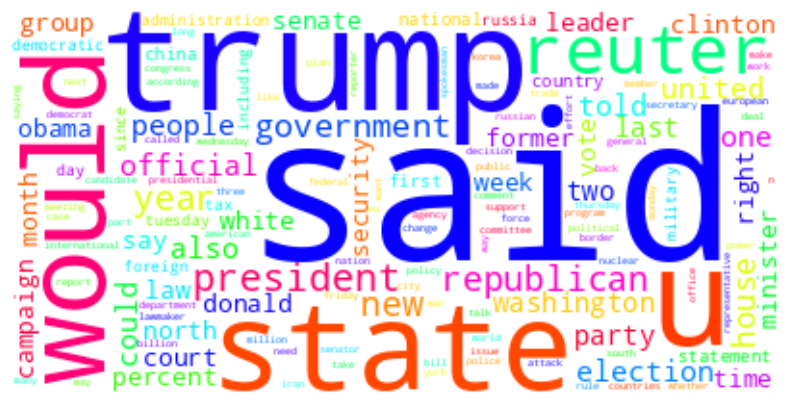

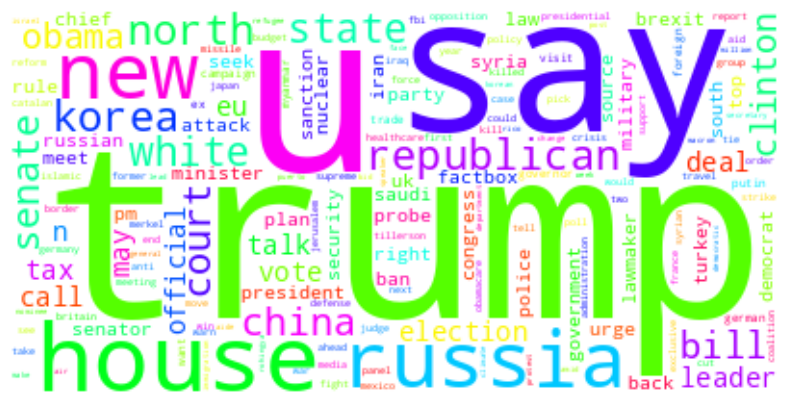

In [45]:
#wordcloud true article
true_article = article[article['isFake'] == 0]
true_article_text = " ".join(true_article['text'].astype(str).values.tolist()).lower()
true_article_title= " ".join(true_article['title'].astype(str).values.tolist()).lower()

display_wordcloud(corpus=true_article_text)
display_wordcloud(corpus=true_article_title)

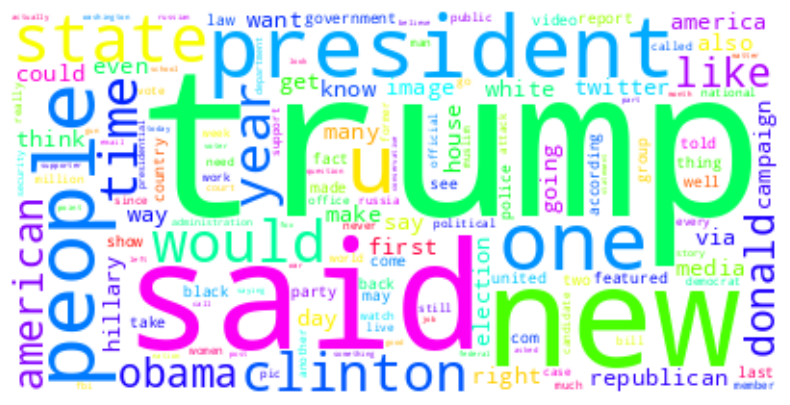

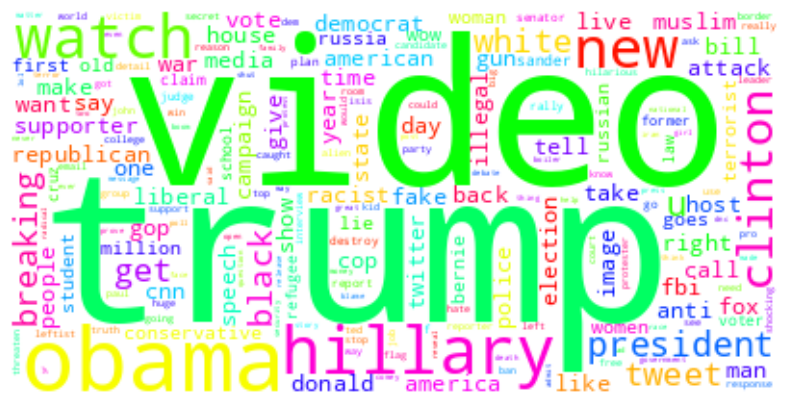

In [46]:
#wordcloud fake article
fake_article=article[article['isFake']!=0]
fake_article_text = " ".join(fake_article['text'].astype(str).values.tolist()).lower()
fake_article_title=" ".join(fake_article['title'].astype(str).values.tolist()).lower()

display_wordcloud(corpus=fake_article_text)
display_wordcloud(corpus=fake_article_title)

## PréProcessing

### Extraction et traitement de la date de publication

In [47]:
# 1) Liste globale pour stocker les dates non parsées
invalid_split    = []
invalid_month    = []
invalid_convert  = []
invalid_format   = []  # pour les URL ou chaînes non datables

# Dictionnaire complet, mois plein + abréviations anglais/français
month_mapping = {
    # EN plein
    'january':1,   'february':2,  'march':3,   'april':4,
    'may':5,       'june':6,      'july':7,    'august':8,
    'september':9, 'october':10,  'november':11,'december':12,
    # EN abbr.
    'jan':1, 'feb':2, 'mar':3, 'apr':4,
    'jun':6, 'jul':7, 'aug':8, 'sep':9,
    'oct':10,'nov':11,'dec':12,
    # FR plein
    'janvier':1,  'février':2, 'fevrier':2,
    'mars':3,     'avril':4,   'mai':5,
    'juin':6,     'juillet':7, 'août':8,   'aout':8,
    'septembre':9,'octobre':10,'novembre':11,'décembre':12,'decembre':12,
    # FR abbr. (facultatif)
    'janv':1, 'févr':2, 'fevr':2, 'avr':4, 'juill':7
}

def split_date(date_str):
    # --- nettoyage de base ---
    orig = date_str
    clean = date_str.strip().strip("'\"")
    # URL ou chemin d’image → pas une date
    if clean.lower().startswith(('http://','https://','www.')):
        invalid_format.append(orig)
        return pd.Series([None, None, None])
    # supprimer virgules superflues
    clean = clean.replace(',', '')
    # --- casing 1 : format à tirets DD-MMM-YY ---
    if clean.count('-') == 2 and len(clean.split()) == 1:
        d_str, m_str, y_str = clean.split('-')
        # convert mois
        month = month_mapping.get(m_str.lower())
        if month is None:
            invalid_month.append(orig)
        # convert jour
        try:
            day = int(d_str)
        except ValueError:
            invalid_convert.append(orig)
            day = None
        # convert année (2 ou 4 chiffres)
        try:
            y = int(y_str)
            year = 2000 + y if y < 100 else y
        except ValueError:
            invalid_convert.append(orig)
            year = None

        return pd.Series([day, month, year])

    # --- casing 2 : format classique "MonthName DD YYYY" ---
    parts = clean.split()
    if len(parts) != 3:
        invalid_split.append(orig)
        return pd.Series([None, None, None])

    month_str, day_str, year_str = parts
    # mapping mois
    month = month_mapping.get(month_str.lower())
    if month is None:
        invalid_month.append(orig)
    # conversion jour/année
    try:
        day = int(day_str)
    except ValueError:
        invalid_convert.append(orig)
        day = None
    try:
        year = int(year_str)
    except ValueError:
        invalid_convert.append(orig)
        year = None

    return pd.Series([day, month, year])

# 1) On crée les colonnes
article[['day','month','year']] = article['date'].apply(split_date)

# 2) On repère les lignes invalides
mask_invalid = article[['day','month','year']].isna().any(axis=1)

# 3) On extrait les dates originales correspondantes
invalid_dates = article.loc[mask_invalid, 'date']

# 4) On affiche
print(f"Sur {len(article)} lignes, {mask_invalid.sum()} ont au moins un None.")
print("Exemples de valeurs problématiques:")
for iv in invalid_dates.unique():
    print(iv)


Sur 44898 lignes, 10 ont au moins un None.
Exemples de valeurs problématiques:
https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/
https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg
https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg
https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/
MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]
https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/


In [48]:
#supprimer les lignes invalides
article = article[~mask_invalid].reset_index(drop=True)

### Définition de la fonction de préprocessing

In [49]:
def preprocess_text(texts, language="english", stopwords=None, normalizer="stem"):
    valid_normalizer = (None, "stem", "lemma")
    if normalizer not in valid_normalizer:
        raise ValueError(f"`normalizer` must be in {valid_normalizer}")

    def process_one(text):
        text = str(text).lower()
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'(http|www)\S*', '', text)
        text = re.sub(r'\S*@\S*\s*', '', text)
        text = re.sub(r'[^\w\s]', ' ', text)

        tokens = word_tokenize(text)
        if isinstance(stopwords, (set, list, tuple)):
            tokens = [w for w in tokens if w not in stopwords]
        if normalizer == "stem":
            stemmer = SnowballStemmer(language, ignore_stopwords=True)
            tokens = [stemmer.stem(w) for w in tokens]
        return " ".join(tokens)

    # Si input est DataFrame, transformer en Series
    if isinstance(texts, pd.DataFrame):
        texts = texts.iloc[:, 0]

    # Appliquer à chaque élément
    return texts.apply(process_one)


### Suppression des mots fréquents

In [50]:
class FrequencyFilter(BaseEstimator, TransformerMixin):
    def __init__(self, min_df=0.05, max_df=0.95):
        self.min_df = min_df
        self.max_df = max_df
        self.vectorizer = CountVectorizer(min_df=self.min_df, max_df=self.max_df)

    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self

    def transform(self, X):
        X_counts = self.vectorizer.transform(X)
        filtered = []
        vocab = self.vectorizer.get_feature_names_out()
        for row in X_counts:
            indices = row.nonzero()[1]
            words = [vocab[i] for i in indices]
            filtered.append(" ".join(words))
        return filtered

### Pipeline pour le title et le text

In [51]:
text_pipeline = Pipeline([
    ("preprocess", FunctionTransformer(preprocess_text, validate=False)),
    ("freq_filter", FrequencyFilter(min_df=0.05, max_df=0.95)),
    ("tfidf", TfidfVectorizer(max_features=5000, stop_words="english"))
])

title_pipeline = Pipeline([
    ("preprocess", FunctionTransformer(preprocess_text, validate=False)),
    ("freq_filter", FrequencyFilter(min_df=0.05, max_df=0.95)),
    ("tfidf", TfidfVectorizer(max_features=3000, stop_words="english"))
])

### Récupération des variables pour la modélisation

In [52]:
used_base=article[['text','title','subject','day','month','year','isFake']].copy()
used_base.head()

,text,title,subject,day,month,year,isFake
0,"Donald Trump s White House is in chaos, and th...",BREAKING: GOP Chairman Grassley Has Had Enoug...,News,21.0,7.0,2017.0,1
1,Now that Donald Trump is the presumptive GOP n...,Failed GOP Candidates Remembered In Hilarious...,News,7.0,5.0,2016.0,1
2,Mike Pence is a huge homophobe. He supports ex...,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,News,3.0,12.0,2016.0,1
3,SAN FRANCISCO (Reuters) - California Attorney ...,California AG pledges to defend birth control ...,politicsNews,6.0,10.0,2017.0,0
4,Twisted reasoning is all that comes from Pelos...,AZ RANCHERS Living On US-Mexico Border Destroy...,politics,25.0,4.0,2017.0,1


## Modélisation

### Division des données en train et test

In [53]:
X = used_base[["text", "title", 'subject', "day", "month", "year"]]
y = used_base["isFake"]

# Split des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Création du transformeur pour la vectorisation

In [54]:
vectorizer = ColumnTransformer(transformers=[
    ("text_vec", text_pipeline, "text"),
    ("title_vec", title_pipeline, "title"),
    ("subject_ohe", OneHotEncoder(handle_unknown="ignore"), ["subject"]),
    ("numeric", "passthrough", ["day", "month", "year"])
])

### Construction du pipeline pour la Regression Logistique

In [55]:
pipeline_reglog = Pipeline(steps=[
    ("vectorize", vectorizer),
    ("clf", LogisticRegression())
])

# Entraînement du modèle
pipeline_reglog.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorize',
                 ColumnTransformer(transformers=[('text_vec',
                                                  Pipeline(steps=[('preprocess',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x7a7539b59b20>)),
                                                                  ('freq_filter',
                                                                   FrequencyFilter()),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   stop_words='english'))]),
                                                  'text'),
                                                 ('title_vec',
                                                  Pipeline(steps=[('preprocess',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x7a7539b59b20>)),
                                                                  ('freq_filter',
                                                                   FrequencyFilter()),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=3000,
                                                                                   stop_words='english'))]),
                                                  'title'),
                                                 ('subject_ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subject']),
                                                 ('numeric', 'passthrough',
                                                  ['day', 'month', 'year'])])),
                ('clf', LogisticRegression())])

### Prédiction et évaluation

In [56]:
y_pred_reglog = pipeline_reglog.predict(X_test)
print(classification_report(y_test, y_pred_reglog, target_names=["Fake", "True"]))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4284
        True       1.00      1.00      1.00      4694

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



In [57]:
#f1-score
print(f1_score(y_test, y_pred_reglog))

1.0


### Construction du pipeline pour le Multinomial NB

In [58]:
pipeline_mnb = Pipeline(steps=[
    ("vectorize", vectorizer),
    ("clf", MultinomialNB())

])

# Entraînement du modèle
pipeline_mnb.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 ColumnTransformer(transformers=[('text_vec',
                                                  Pipeline(steps=[('preprocess',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x7a7539b59b20>)),
                                                                  ('freq_filter',
                                                                   FrequencyFilter()),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   stop_words='english'))]),
                                                  'text'),
                                                 ('title_vec',
                                                  Pipeline(steps=[('preprocess',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x7a7539b59b20>)),
                                                                  ('freq_filter',
                                                                   FrequencyFilter()),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=3000,
                                                                                   stop_words='english'))]),
                                                  'title'),
                                                 ('subject_ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subject']),
                                                 ('numeric', 'passthrough',
                                                  ['day', 'month', 'year'])])),
                ('clf', MultinomialNB())])

### Prédiction et évaluation

In [61]:
print(f1_score(y_test, y_pred_reglog))

1.0


In [63]:
y_pred_mnb = pipeline_mnb.predict(X_test)
print(classification_report(y_test, y_pred_mnb, target_names=["Fake", "True"]))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4284
        True       1.00      1.00      1.00      4694

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



In [64]:
#score
print(f1_score(y_test, y_pred_mnb))

1.0


### Construction du pipeline pour le Gradient Boosting

In [65]:
pipeline_gbc = Pipeline(steps=[
    ("vectorize", vectorizer),
    ("clf", GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
])

# Entraînement du modèle
pipeline_gbc.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 ColumnTransformer(transformers=[('text_vec',
                                                  Pipeline(steps=[('preprocess',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x7a7539b59b20>)),
                                                                  ('freq_filter',
                                                                   FrequencyFilter()),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   stop_words='english'))]),
                                                  'text'),
                                                 ('title_vec',
                                                  Pipeline(steps=[('preprocess',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x7a7539b59b20>)),
                                                                  ('freq_filter',
                                                                   FrequencyFilter()),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=3000,
                                                                                   stop_words='english'))]),
                                                  'title'),
                                                 ('subject_ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subject']),
                                                 ('numeric', 'passthrough',
                                                  ['day', 'month', 'year'])])),
                ('clf', GradientBoostingClassifier(random_state=42))])

### Prédiction et évaluation

In [66]:
y_pred_gbc = pipeline_reglog.predict(X_test)
print(classification_report(y_test, y_pred_gbc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4284
           1       1.00      1.00      1.00      4694

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



In [67]:
#score
print(f1_score(y_test, y_pred_gbc))

1.0


### Construction du pipeline pour le Random Forest

In [68]:
pipeline_rf = Pipeline(steps=[
    ("vectorize", vectorizer),
    ("clf",RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entraînement du modèle
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 ColumnTransformer(transformers=[('text_vec',
                                                  Pipeline(steps=[('preprocess',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x7a7539b59b20>)),
                                                                  ('freq_filter',
                                                                   FrequencyFilter()),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   stop_words='english'))]),
                                                  'text'),
                                                 ('title_vec',
                                                  Pipeline(steps=[('preprocess',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x7a7539b59b20>)),
                                                                  ('freq_filter',
                                                                   FrequencyFilter()),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=3000,
                                                                                   stop_words='english'))]),
                                                  'title'),
                                                 ('subject_ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subject']),
                                                 ('numeric', 'passthrough',
                                                  ['day', 'month', 'year'])])),
                ('clf', RandomForestClassifier(random_state=42))])

### Prédiction et évaluation

In [69]:
y_pred_rf = pipeline_reglog.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4284
           1       1.00      1.00      1.00      4694

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



In [70]:
#score
print(f1_score(y_test, y_pred_rf))

1.0


Le modèle retenue est finalement le Multinomial NB du faite de

In [71]:
joblib.dump(pipeline_mnb, MODEL_DIR / "pipeline_mnb.pkl")

['/content/models/pipeline_mnb.pkl']

In [72]:

article.to_csv(DATA_DIR / "article_cleaned.csv", index=False)
used_base.to_csv(DATA_DIR / "used_base.csv", index=False)